Todo : 
- implement UCB1
- check if there are other algorithms
- find good experiments to compare algorithms (Penser à des experiences ou le meilleur bras n'est pas evident à trouver/ passe au dessus qu'a la fin par ex)
- reproduce experiment of https://arxiv.org/pdf/1506.03271.pdf (Section 4)

3 algorithms : Exp3, Exp3.P, Exp3-IX

# Exp-3 algorithms

ref :  https://jeremykun.com/2013/11/08/adversarial-bandits-and-the-exp3-algorithm/

https://arxiv.org/pdf/1506.03271.pdf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# need to define class arm (cf TD2)
class Arm():
    """ 
    Defines an arm with arbitrary finite sequence of reward
    """
    def __init__(self, rewards_sequence):
        self.rewards = rewards_sequence
    
    def sample(self, t):
        return self.rewards[t]

In [4]:
class bernoulliArm():
    def __init__(self, mean):
        self.mean = mean
    
    def sample(self, t):
        return np.random.binomial(p=self.mean, n=1)

In [5]:
class evolvingBernoulliArm():
    def __init__(self, means, switching_time):
        self.means = means
        self.switching_time = switching_time
    
    def sample(self, t):
        if t <= self.switching_time:
            return np.random.binomial(p=self.means[0], n=1)
        else:
            return np.random.binomial(p=self.means[1], n=1)

In [85]:
def exp3_Bianchi(MAB, T, eta):
    """
    Exp3 algorithm as in "Regret Analysis of Stochastic and 
    Nonstochastic Multi-armed Bandit Problems"
    by Bubeck and Bianchi
    
    MAB: list of arms from Arm class
    T: time horizon
    eta: list of length t of exploration parameters of Exp3
    """
    
    K = len(MAB) # number of arms
    
    # initialize rewards estimation   
    R = np.zeros(K)
    # History of rewards and weights
    reward_hist = []
    weights_hist = []
    drawn_arms = []
    for t in range(T):
        p = np.exp(eta * (R - np.max(R)))
        p /= np.sum(p)
        
        # Draw arm index
        drawn_index = np.random.choice(a=K, p=p) 
        # Draw corresponding reward
        drawn_reward = MAB[drawn_index].sample(t) 
        
        # Compute estimated reward
        estimated_reward = drawn_reward / p[drawn_index] 
        
        #update rewards estimation 
        R[drawn_index] += drawn_reward / p[drawn_index]
        
        # Save obtained reward and weights
        reward_hist.append(drawn_reward)
        weights_hist.append(np.exp(eta * R))
        drawn_arms.append(drawn_index)
    return reward_hist, weights_hist, drawn_arms

def exp3P_Bianchi(MAB, T, eta, gamma, beta):
    """
    Exp3.P algorithm as in "Regret Analysis of Stochastic and 
    Nonstochastic Multi-armed Bandit Problems"
    by Bubeck and Bianchi
    
    MAB: list of arms from Arm class
    T: time horizon
    eta: parameter used in the exponential
    gamma: random exploration probability
    beta: added bias
    """
    
    K = len(MAB) # number of arms
    
    # initialize rewards estimation   
    R = np.zeros(K)
    # History of rewards and weights
    reward_hist = []
    weights_hist = []
    for t in range(T):
        p = np.exp(eta * (R - np.max(R)))
        p /= np.sum(p)
        p = (1 - gamma) * p + gamma / K
        
        # Draw arm index
        drawn_index = np.random.choice(a=K, p=p) 
        # Draw corresponding reward
        drawn_reward = MAB[drawn_index].sample(t) 
        
        # Compute estimated reward
        estimated_reward = (drawn_reward + beta) / p[drawn_index] 
        
        #update rewards estimation 
        R[drawn_index] += drawn_reward / p[drawn_index]
        
        # Save obtained reward and weights
        reward_hist.append(drawn_reward)
        weights_hist.append(np.exp(eta * R))
    return reward_hist, weights_hist

In [7]:
def exp3_IX(MAB, T, eta, gamma):
    """
    Exp3-IX algorithm as in Explore no more (Neu)
    MAB: list of arms from Arm class
    T: the time horizon
    eta: learning rate
    gamma: implicit exploration parameter
    """
    
    K = len(MAB) # number of arms
    W = np.ones(K) # initialize weights
    
    # History of rewards and weights
    reward_hist = []
    weights_hist = []
    
    R = np.zeros(K) #estimated rewards
    
    for t in range(T):
        
        # Set probabilities of drawing each arm

        p = np.exp(eta * (R - np.max(R))) / np.sum(np.exp(eta * (R - np.max(R))))

        # Draw arm index
        drawn_index = np.random.choice(a=K, p=p)
        
        # Draw corresponding reward
        drawn_reward = MAB[drawn_index].sample(t) 
        
        # Compute estimated reward with implicit exploration
        estimated_reward = drawn_reward/(p[drawn_index] + gamma) 
        
        R[drawn_index] += estimated_reward #update rewards estimation
        
        # Save obtained reward and weights
        reward_hist.append(drawn_reward) 
        weights_hist.append(np.exp(eta * R))
    return reward_hist, weights_hist

In [8]:
def UCB1(MAB, T, rho):
    n_iter = 0
    K = len(MAB)
    means_empirical = np.array([0. for i in range(K)])
    number_arms_draw = np.array([1 for i in range(K)])
    rew_draws = [[], []]

    # initialisation phases
    while n_iter < min(K, T):
        reward = MAB[n_iter].sample(n_iter)
        rew_draws[0].append(reward)
        rew_draws[1].append(n_iter)
        means_empirical[n_iter] += reward
        n_iter += 1
    # UCB
    while n_iter < T:
        i = np.argmax(means_empirical + rho *
                      (np.log(n_iter + 1) / (2 * number_arms_draw))**2)
        # drawing
        reward = MAB[i].sample(n_iter)
        rew_draws[0].append(reward)
        rew_draws[1].append(i)
        # update statistics
        number_arms_draw[i] += 1
        means_empirical[i] += ((reward - means_empirical[i]) / (number_arms_draw[i]))
        # increment
        n_iter += 1
    return rew_draws

In [9]:
def Random(MAB, T):
    
    reward_hist = []
    for i in range(T):
        index = np.random.randint(len(MAB))
        reward = MAB[index].sample(i)
        
        reward_hist.append(reward)
    return reward_hist

In [10]:
# we define gaussian trajectories normalized to lie in [0, 1]

def gaussian_traj(T):
    gp = np.cumsum(np.random.normal(0, 2, T))

    # normalization (to have rewards in [0, 1]) :
    gp += np.abs(min(gp))
    gp /= max(gp)
    return(gp)

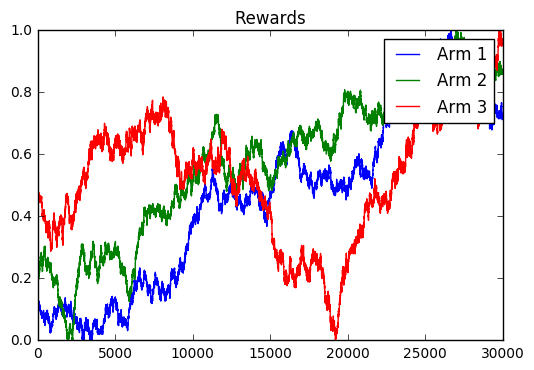

In [11]:
T = 30000

arm1 = Arm(gaussian_traj(T))
arm2 = Arm(gaussian_traj(T))
arm3 = Arm(gaussian_traj(T))

MAB = [arm1, arm2, arm3]

plt.plot(arm1.rewards)
plt.plot(arm2.rewards)
plt.plot(arm3.rewards)
plt.legend(['Arm 1', 'Arm 2', 'Arm 3'])
plt.title('Rewards')

### Calculate best arm at round t

In [22]:
arm1_cumsum = np.cumsum(arm1.rewards)
arm2_cumsum = np.cumsum(arm2.rewards)
arm3_cumsum = np.cumsum(arm3.rewards)

best_action_rew = np.zeros(T)

for t in range(T):
    best_action_rew[t] = max(arm1_cumsum[t], arm2_cumsum[t], arm3_cumsum[t])

## Weak regret bound of Exp3 if the number of rounds is known

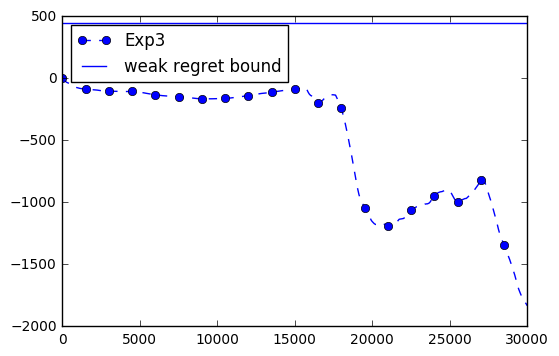

In [23]:
K = len(MAB)
eta = np.sqrt(2 * np.log(K) / T * K)
etas = [eta for _ in range(T)]

rew_exp3 = np.zeros(T)
n_iter = 20

for i in range(n_iter):
    rew_exp3 += exp3_Bianchi(MAB, T, etas)
    
rew_exp3 /= n_iter
    
exp3_cumsum = np.cumsum(rew_exp3)
plt.plot(exp3_cumsum - best_action_rew, '--o', markevery=1500, label="Exp3")

plt.axhline(np.sqrt( 2 * T * K * np.log(K)), label="weak regret bound")
plt.legend(loc="upper left")

## Weak regret of Exp3 when the number of rounds is uknown

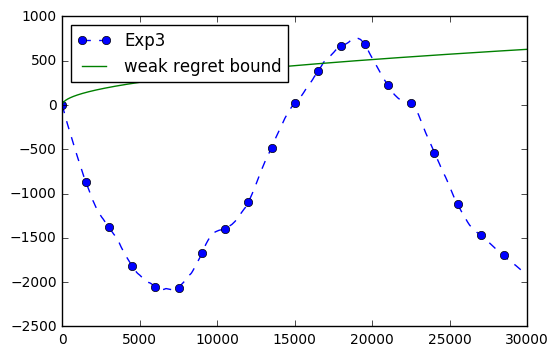

In [30]:
K = len(MAB)
etas = [np.sqrt(2 * np.log(K) / (t + 1) * K) for t in range(T)]

rew_exp3 = np.zeros(T)
n_iter = 1000

for i in range(n_iter):
    rew_exp3 += exp3_Bianchi(MAB, T, etas)
rew_exp3 /= n_iter

    
exp3_cumsum = np.cumsum(rew_exp3)
plt.plot(exp3_cumsum - best_action_rew, '--o', markevery=1500, label="Exp3")

plt.plot([np.sqrt(4 * t * K * np.log(K)) for t in range(T)], label="weak regret bound")
plt.legend(loc="upper left")

## Regret of Exp3.P

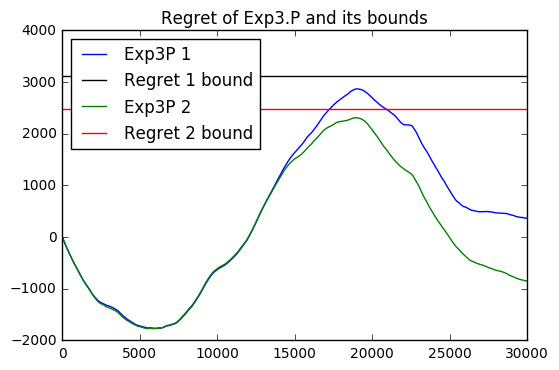

In [34]:
K = len(MAB)
delta = 0.05
eta = 0.95 * np.sqrt(np.log(K) / (T * K))
gamma = 1.05 * np.sqrt(np.log(K) * K / T)
beta = np.sqrt(np.log(K / delta) /  (T * K))

#calculate best arm at each round
best_action_rew = np.zeros(T)
for t in range(T):
    best_action_rew[t] = max(arm1_cumsum[t], arm2_cumsum[t], arm3_cumsum[t])

#first type of regret bound
rew_exp3P = exp3P_Bianchi(MAB, T, eta, gamma, beta)

exp3P_cumsum = np.cumsum(rew_exp3P)

plt.plot(exp3P_cumsum - best_action_rew, label="Exp3P 1") 
plt.axhline(5.15 * np.sqrt(T * K * np.log(K / delta)), c="black", label="Regret 1 bound")

#second type of regret bound
beta = np.sqrt(np.log(K) /  (T * K))

rew_exp3P = exp3P_Bianchi(MAB, T, eta, gamma, beta)
exp3P_cumsum = np.cumsum(rew_exp3P)
plt.plot(exp3P_cumsum - best_action_rew, label="Exp3P 2") 
plt.axhline(5.15 * np.sqrt(T * K * np.log(K)) + np.sqrt(T * K / np.log(K)) * np.log(1 / delta), c="red", label="Regret 2 bound")

plt.legend(loc="upper left")
plt.title("Regret of Exp3.P and its bounds")

## Weak regret of Exp3.P

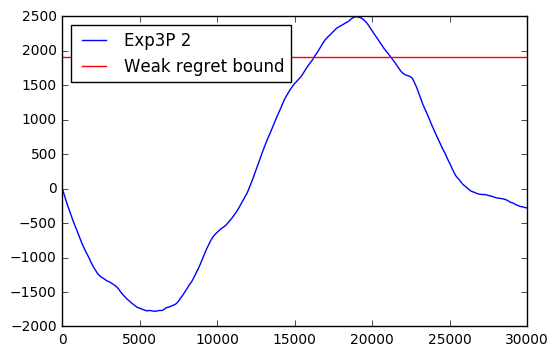

In [49]:
#hyperparameters
eta = 0.95 * np.sqrt(np.log(K) / (T * K))
gamma = 1.05 * np.sqrt(np.log(K) * K / T)
beta = np.sqrt(np.log(K) /  (T * K))

#calculate best arm at each round
best_action_rew = np.zeros(T)
for t in range(T):
    best_action_rew[t] = max(arm1_cumsum[t], arm2_cumsum[t], arm3_cumsum[t])

rew_exp3P = np.zeros(T)
n_iter = 100
for i in range(n_iter):
    rew_exp3P += exp3P_Bianchi(MAB, T, eta, gamma, beta)
rew_exp3P /= n_iter

exp3P_cumsum = np.cumsum(rew_exp3P)

plt.plot(exp3P_cumsum - best_action_rew, label="Exp3P 2") 
plt.axhline(5.15 * np.sqrt(T * K * np.log(K)) + np.sqrt(T * K / np.log(K)), c="red", label="Weak regret bound")

plt.legend(loc="upper left")

### Compairison of different algorithms on gaussian arms

In [30]:
#set up the parameters

K = len(MAB)
eta = np.sqrt(2 * np.log(K) / T * K)
etas_exp3 = [eta for _ in range(T)]

delta = 0.05
eta = 0.95 * np.sqrt(np.log(K) / (T * K))
gamma = 1.05 * np.sqrt(np.log(K) * K / T)
beta = np.sqrt(np.log(K / delta) /  (T * K))

In [36]:
rew = exp3_Bianchi(MAB, T, eta=etas)
rew_P = exp3P_Bianchi(MAB, T, beta=beta, gamma=gamma, eta=eta)
rew_IX, _ = exp3_IX(MAB, T, eta=eta, gamma=0.5)
rew_UCB, _ = UCB1(MAB, T, rho=0.2)
rew_random = Random(MAB, T)

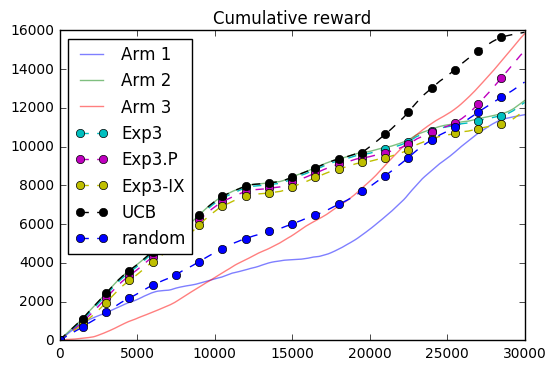

In [37]:
arm1_cumsum = np.cumsum(arm1.rewards)
arm2_cumsum = np.cumsum(arm2.rewards)
arm3_cumsum = np.cumsum(arm3.rewards)
exp3_cumsum = np.cumsum(rew)
exp3_P_cumsum = np.cumsum(rew_P)
exp3_IX_cumsum = np.cumsum(rew_IX)
UCB_cumsum = np.cumsum(rew_UCB)
rew_cumsum = np.cumsum(rew_random)

plt.plot(arm1_cumsum, alpha=0.5, label="Arm 1")
plt.plot(arm2_cumsum, alpha=0.5, label="Arm 2")
plt.plot(arm3_cumsum, alpha=0.5, label="Arm 3")

plt.plot(exp3_cumsum, '--o', markevery=1500, label="Exp3")

plt.plot(exp3_P_cumsum, '--o', markevery=1500, label="Exp3.P")
plt.plot(exp3_IX_cumsum, '--o', markevery=1500, label="Exp3-IX")
plt.plot(UCB_cumsum, '--o', markevery=1500, label="UCB")
plt.plot(rew_cumsum, '--o', markevery=1500, label="random")

plt.legend(loc="upper left")
plt.title("Cumulative reward")

### Simple vicious adversary

At each turn only one of the arms has a 1-reward

Exp3 are much better than UCB, but appears more or less as a random algorithm

In [34]:
T = 10000

nb_arms = 10

Rewards = [[0 for _ in range(T)] for _ in range(nb_arms)]
for i in range(T):
    Rewards[i % nb_arms][i] = 1
MAB = [Arm(rewards_sequence=Rewards[i]) for i in range(nb_arms)]

In [35]:
K = len(MAB)
base_parameter = np.sqrt(np.log(K) / (T * K))

In [36]:
T = 10000
T2 = 5000

n_iter = 50
nb_multipliers = 10
R_T = np.zeros((3, nb_multipliers, n_iter))
R_T2 = np.zeros((3, nb_multipliers, n_iter))

for j, multiplier in enumerate(np.linspace(1e-3, 5e1, nb_multipliers)):
    print(multiplier)
    for i in range(50):
        eta = multiplier * base_parameter
        rew, _ = exp3_Bianchi(MAB, T, eta=[eta for _ in range(T)])

        rew_P, _ = exp3P_Bianchi(MAB, T, beta=eta, gamma=K * eta, eta=eta)
        rew_IX, _ = exp3_IX(MAB, T, eta, eta / 2)

        exp3_T2, exp3_P_T2, exp3_IX_T2 = np.sum(
            rew[: T2]), np.sum(rew_P[: T2]), np.sum(rew_IX[: T2])

        exp3_T, exp3_P_T, exp3_IX_T = exp3_T2 + np.sum(rew[T2:]), exp3_P_T2 + np.sum(rew_P[T2:]
                                                                                     ), exp3_IX_T2 + np.sum(rew_IX[T2:])

        R_T2[:, j, i] = [exp3_T2, exp3_P_T2, exp3_IX_T2]
        R_T[:, j, i] = [exp3_T, exp3_P_T, exp3_IX_T]

0.001


ValueError: operands could not be broadcast together with shapes (10000,) (10,) 

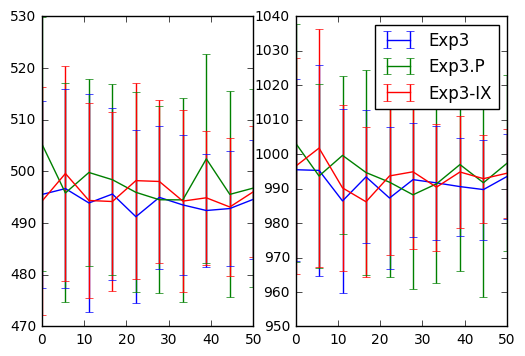

In [105]:
R_T_mean = np.mean(R_T, axis=2)
R_T2_mean = np.mean(R_T2, axis=2)
R_T_std = np.std(R_T, axis=2)
R_T2_std = np.std(R_T2, axis=2)

plt.subplot(1,2,1)
plt.errorbar(np.linspace(0, 50, 10), R_T2_mean[0], R_T2_std[0], label="Exp3")
plt.errorbar(np.linspace(0, 50, 10), R_T2_mean[1], R_T2_std[1], label="Exp3.P")
plt.errorbar(np.linspace(0, 50, 10), R_T2_mean[2], R_T2_std[2], label="Exp3.P")

plt.subplot(1,2,2)
plt.errorbar(np.linspace(0, 50, 10), R_T_mean[0], R_T_std[0], label="Exp3")
plt.errorbar(np.linspace(0, 50, 10), R_T_mean[1], R_T_std[1], label="Exp3.P")
plt.errorbar(np.linspace(0, 50, 10), R_T_mean[2], R_T_std[2], label="Exp3-IX")
plt.legend()

In [67]:
rew = exp3_Bianchi(MAB, T, eta=etas)
rew_P = exp3P_Bianchi(MAB, T, beta=beta, gamma=gamma, eta=eta)
rew_IX, _ = exp3_IX(MAB, T, eta=eta, gamma=0.5)
rew_UCB, _ = UCB1(MAB, T, rho=0.7)
rew_random = Random(MAB, T)

In [74]:
#set up the parameters

K = len(MAB)
eta_exp3 = np.sqrt(2 * np.log(K) / T * K)

delta = 0.05
eta = 0.95 * np.sqrt(np.log(K) / (T * K))
gamma = 1.05 * np.sqrt(np.log(K) * K / T)
beta = np.sqrt(np.log(K / delta) /  (T * K))

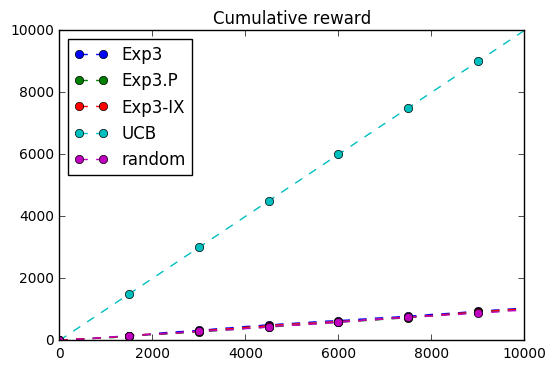

In [68]:
exp3_cumsum = np.cumsum(rew)
exp3_P_cumsum = np.cumsum(rew_P)
exp3_IX_cumsum = np.cumsum(rew_IX)
UCB_cumsum = np.cumsum(rew_UCB)
rew_cumsum = np.cumsum(rew_random)

plt.plot(exp3_cumsum, '--o', markevery=1500, label="Exp3")

plt.plot(exp3_P_cumsum, '--o', markevery=1500, label="Exp3.P")
plt.plot(exp3_IX_cumsum, '--o', markevery=1500, label="Exp3-IX")
plt.plot(UCB_cumsum, '--o', markevery=1500, label="UCB")
plt.plot(rew_cumsum, '--o', markevery=1500, label="random")

plt.legend(loc="upper left")
plt.title("Cumulative reward")

# Exp3-IX expriment

Ref : https://arxiv.org/pdf/1506.03271.pdf (Section 4)

10-arm bandit problem where
all losses are independent draws of Bernoulli random variables. 

The mean rewards of arms 1 through 8 are 0.5

The mean reward of arm 9 is $0.5 + \delta$ for all rounds $t = 1, 2, . . . , T$. 

The mean rewards of
arm 10 are changing over time: for rounds $t \leq \frac{T}{2}$, the mean is $0.5 - \delta$, and $0.5 + 4\delta$ afterwards.

/!\ We consider rewards instead of losses (opposite to the article) 

$\beta = \frac{\gamma}{K} = \frac{\eta}{20}$ ou $\beta = \eta$ ???

In [12]:
T = 10000
T2 = 5000
K = 10
delta = 0.1
MAB_IX = [bernoulliArm(0.5) for i in range(8)]
MAB_IX.append(bernoulliArm(0.5 + delta))
MAB_IX.append(evolvingBernoulliArm([0.5 - delta, 0.5 + 4*delta], T/2))

In [13]:
base_parameter = np.sqrt(np.log(K) / T * K)
print(base_parameter)

0.0479852591219


In [53]:
T = 10000
T2 = 5000

n_iter = 50
nb_multipliers = 20
R_T = np.zeros((3, nb_multipliers, n_iter))
R_T2 = np.zeros((3, nb_multipliers, n_iter))

X = np.logspace(-2, 4, nb_multipliers)

for j, multiplier in enumerate(X):
    print(multiplier)
    for i in range(n_iter):
        eta = multiplier * base_parameter
        rew, _ = exp3_Bianchi(MAB_IX, T, eta)

        rew_P, _ = exp3P_Bianchi(MAB_IX, T, beta=eta, gamma=min(0.95, eta), eta=eta)
        rew_IX, _ = exp3_IX(MAB_IX, T, eta, eta / 2)
        exp3_T2, exp3_P_T2, exp3_IX_T2 = np.sum(
            rew[: T2]), np.sum(rew_P[: T2]), np.sum(rew_IX[: T2])

        exp3_T, exp3_P_T, exp3_IX_T = exp3_T2 + np.sum(rew[T2:]), exp3_P_T2 + np.sum(rew_P[T2:]
                                                                                     ), exp3_IX_T2 + np.sum(rew_IX[T2:])
        
        R_T2[:, j, i] = [exp3_T2, exp3_P_T2, exp3_IX_T2]
        R_T[:, j, i] = [exp3_T, exp3_P_T, exp3_IX_T]

0.01
0.0206913808111
0.0428133239872
0.088586679041
0.183298071083


/home/sel/.local/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: overflow encountered in exp


0.379269019073
0.784759970351
1.62377673919
3.35981828628


/home/sel/.local/lib/python3.5/site-packages/ipykernel/__main__.py:77: RuntimeWarning: overflow encountered in exp
/home/sel/.local/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: overflow encountered in exp


6.95192796178
14.3844988829
29.7635144163
61.5848211066
127.42749857
263.665089873
545.559478117
1128.83789168
2335.72146909
4832.93023857
10000.0


In [30]:
UCB_T = []
UCB_T2 = []
for i in range(n_iter):  
    rew_ucb, _ = UCB1(MAB_IX, T, rho=0.2)
    rew_cumsum = np.cumsum(rew_ucb)
    UCB_T.append(rew_cumsum[T - 1])
    UCB_T2.append(rew_cumsum[T2 - 1])

In [27]:
print(np.mean(UCB_T))
print(np.std(UCB_T))
print(np.mean(UCB_T2))
print(np.std(UCB_T2))

2512.46
33.0993715952
48.2950308003
5262.5
5638.46
557.270929082
2748.52
241.302817224


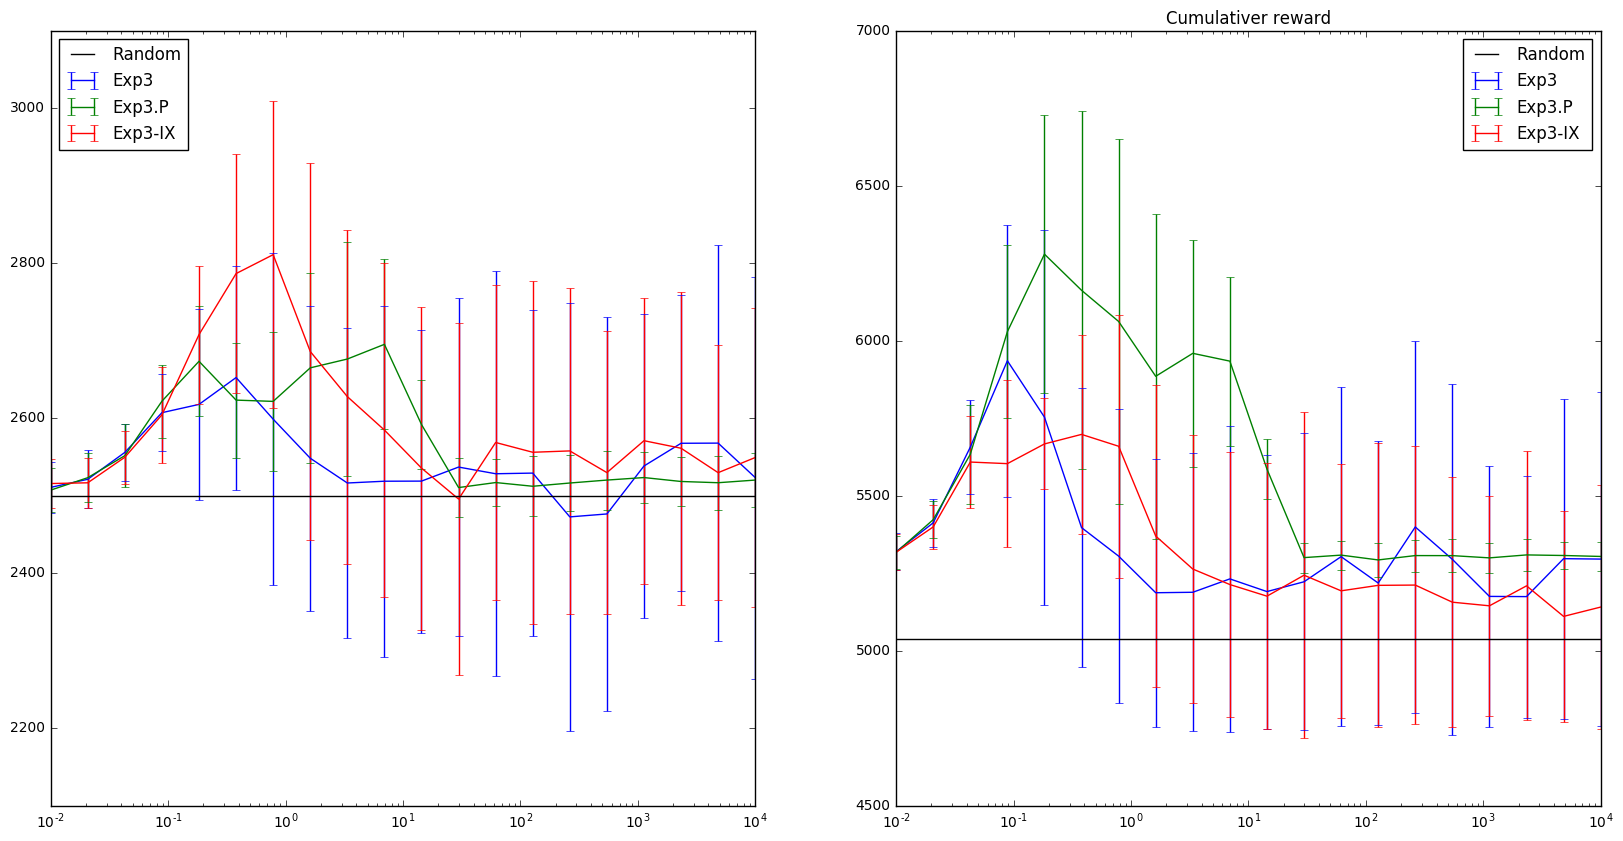

In [59]:
R_T_mean = np.mean(R_T, axis=2)
R_T2_mean = np.mean(R_T2, axis=2)
R_T_std = np.std(R_T, axis=2)
R_T2_std = np.std(R_T2, axis=2)


plt.subplots(figsize=(20,10))
plt.subplot(1,2,1)
plt.semilogx()
plt.errorbar(X, R_T2_mean[0], R_T2_std[0], label="Exp3")
plt.errorbar(X, R_T2_mean[1], R_T2_std[1], label="Exp3.P")
plt.errorbar(X, R_T2_mean[2], R_T2_std[2], label="Exp3-IX")
plt.axhline(2500, c="black", label="Random")
plt.legend(loc="upper left")
plt.subplot(1,2,2)
plt.semilogx()
plt.errorbar(X, R_T_mean[0], R_T_std[0], label="Exp3")
plt.errorbar(X, R_T_mean[1], R_T_std[1], label="Exp3.P")
plt.errorbar(X, R_T_mean[2], R_T_std[2], label="Exp3-IX")
plt.axhline((2 + 0.015) * 2500, c="black", label="Random")
plt.legend()
plt.title("Cumulativer reward")

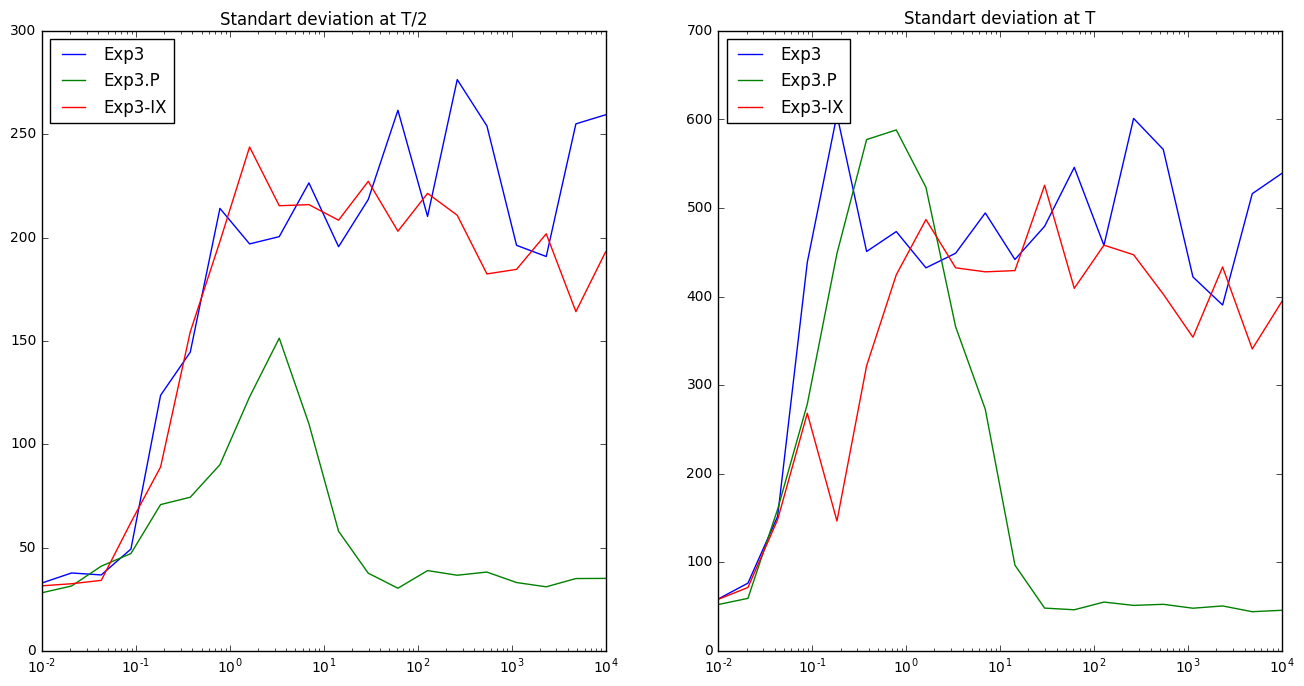

In [74]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(X, R_T2_std[0], label="Exp3")
plt.plot(X, R_T2_std[1], label="Exp3.P")
plt.plot(X, R_T2_std[2], label="Exp3-IX")
plt.legend(loc="upper left")
plt.semilogx()
plt.title("Standart deviation at T/2")
plt.subplot(1, 2, 2)
plt.plot(X, R_T_std[0], label="Exp3")
plt.plot(X, R_T_std[1], label="Exp3.P")
plt.plot(X, R_T_std[2], label="Exp3-IX")
plt.semilogx()
plt.legend(loc="upper left")
plt.title("Standart deviation at T")

In [50]:
T = 10000
T2 = 5000
K = 10
delta = 0.1
MAB_IX = [bernoulliArm(0.5) for i in range(8)]
MAB_IX.append(bernoulliArm(0.5 + delta))
MAB_IX.append(evolvingBernoulliArm([0.5 - delta, 0.5 + 4*delta], T/2))

base_parameter = np.sqrt(np.log(K) / T * K)
eta = 0.1 * base_parameter

Weights = np.zeros((3, T, K))
Rewards = np.zeros((3, T))
nb_iter = 50
for i in range(nb_iter):
    rew, weights_exp = exp3_Bianchi(MAB_IX, T, eta)
    rew_P, weights_expP = exp3P_Bianchi(MAB_IX, T, beta=eta, gamma=min(0.95, eta), eta=eta)
    rew_IX, weights_expIX = exp3_IX(MAB_IX, T, eta, eta / 2)
    rew_cumsum = np.cumsum(rew)
    rewP_cumsum = np.cumsum(rew_P)
    rewIX_cumsum = np.cumsum(rew_IX)
    Rewards += [rew_cumsum, rewP_cumsum, rewIX_cumsum]
    Weights += [weights_exp, weights_expP, weights_expIX]
    
Rewards /= nb_iter
Weights /= nb_iter

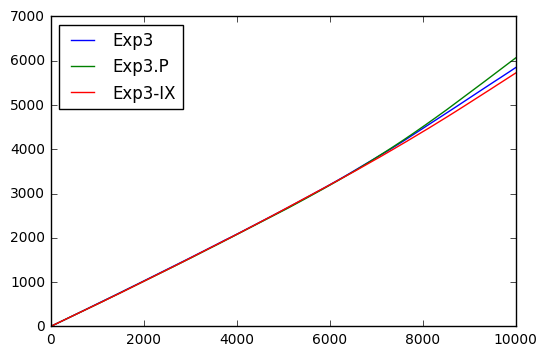

In [51]:
plt.plot(Rewards[0])
plt.plot(Rewards[1])
plt.plot(Rewards[2])
plt.legend(["Exp3", "Exp3.P", "Exp3-IX"], loc="upper left")

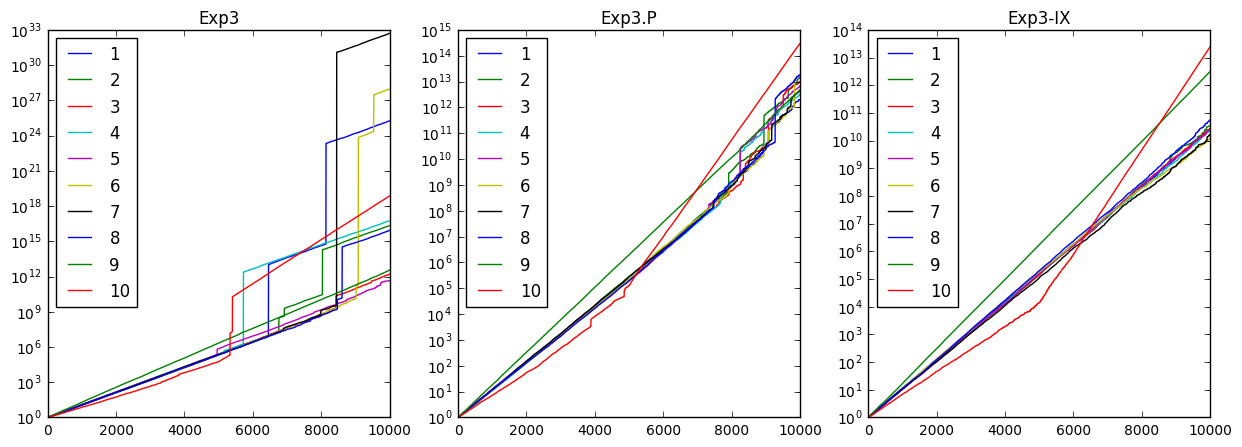

In [52]:
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.plot(Weights[0])
plt.semilogy()
plt.title("Exp3")
plt.legend([i+1 for i in range(10)], loc="upper left")
plt.subplot(1,3,2)
plt.title("Exp3.P")
plt.plot(Weights[1])
plt.semilogy()
plt.legend([i+1 for i in range(10)], loc="upper left")
plt.subplot(1,3,3)
plt.plot(Weights[2])
plt.title("Exp3-IX")
plt.semilogy()
plt.legend([i+1 for i in range(10)], loc="upper left")

## Simple experiment 2 arms

1 arm $\mathcal{B}(0.7)$ up to $\frac{T}{2}$ and then $\mathcal{B}(0.2)$. The other: $\mathcal{B}(0.2)$ then $\mathcal{B}(0.8)$

In [58]:
T = 15000
T2 = 2000
MAB_simple = [evolvingBernoulliArm([0.7, 0.2], T2)]
MAB_simple.append(evolvingBernoulliArm([0.2, 0.8], T2))

In [59]:
K = len(MAB_simple)
eta_exp3 = np.sqrt(2 * np.log(K) / T * K)

delta = 0.05
eta = 0.95 * np.sqrt(np.log(K) / (T * K))
gamma = 1.05 * np.sqrt(np.log(K) * K / T)
beta = np.sqrt(np.log(K / delta) /  (T * K))

In [86]:
nb_iter = 50
Weights = np.zeros((3, T, K))
Rewards = np.zeros((3, T))
nb_iter = 1

for i in range(nb_iter):
    rew, weights_exp, drawn_arms = exp3_Bianchi(MAB_simple, T, eta)
    rew_P, weights_expP = exp3P_Bianchi(MAB_simple, T, beta=eta, gamma=gamma, eta=eta)
    rew_IX, weights_expIX = exp3_IX(MAB_simple, T, eta, eta / 2)
    rew_cumsum = np.cumsum(rew)
    rewP_cumsum = np.cumsum(rew_P)
    rewIX_cumsum = np.cumsum(rew_IX)
    Rewards += [rew_cumsum, rewP_cumsum, rewIX_cumsum]
    Weights += [weights_exp, weights_expP, weights_expIX]
Rewards /= nb_iter
Weights /= nb_iter

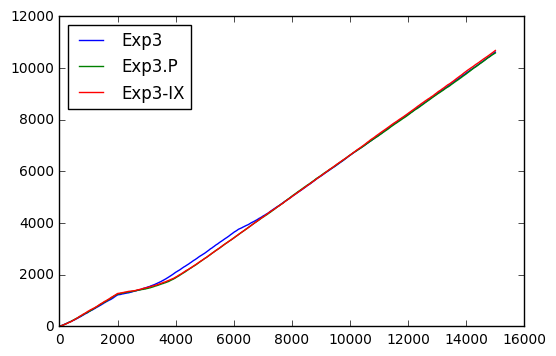

In [87]:
plt.plot(Rewards[0])
plt.plot(Rewards[1])
plt.plot(Rewards[2])
plt.legend(["Exp3", "Exp3.P", "Exp3-IX"], loc="upper left")

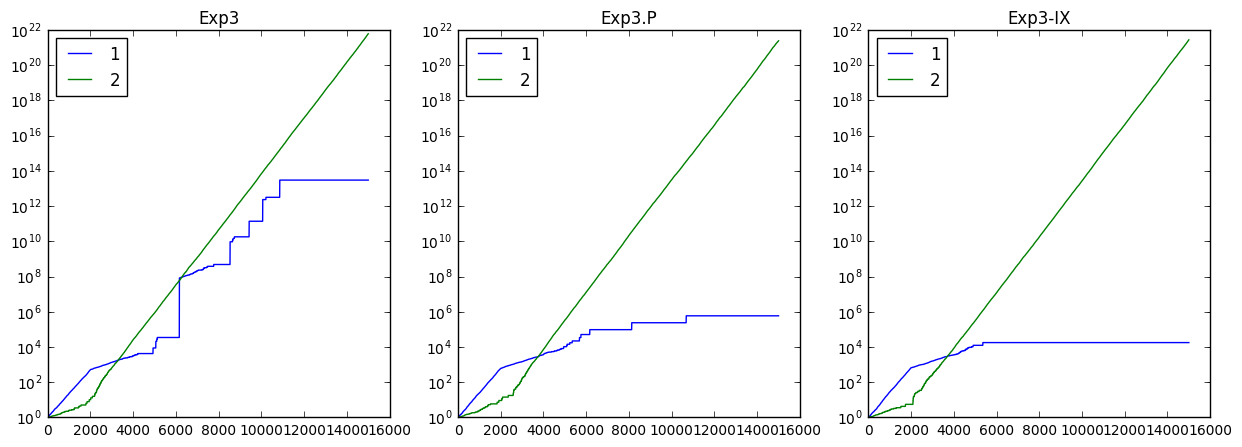

In [88]:
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.plot(Weights[0])
plt.semilogy()
plt.title("Exp3")
plt.legend([i+1 for i in range(10)], loc="upper left")
plt.subplot(1,3,2)
plt.title("Exp3.P")
plt.plot(Weights[1])
plt.semilogy()
plt.legend([i+1 for i in range(10)], loc="upper left")
plt.subplot(1,3,3)
plt.plot(Weights[2])
plt.title("Exp3-IX")
plt.semilogy()
plt.legend([i+1 for i in range(10)], loc="upper left")

In [95]:
print(Weights[0][6180:6150, 0] )

[ 34627.83816559  34627.83816559  34627.83816559  34627.83816559
  34627.83816559  34627.83816559  34627.83816559  34627.83816559
  34627.83816559  34627.83816559  34627.83816559  34627.83816559
  34627.83816559  34627.83816559  34627.83816559  34627.83816559
  34627.83816559  34627.83816559  34627.83816559  34627.83816559]


In [84]:
Rewards[0][6718:6725]

array([ 3798.,  3799.,  3799.,  3800.,  3800.,  3800.,  3801.])